To get file from HDFS to local filesystem, we can use `copyToLocal` option.

In [1]:
!hdfs dfs -copyToLocal /tmp/mkoroleva-309944/ProjectBook.ipynb ./notebook.ipynb

В данном notebook я:
- расписываю, что в столбцах и высказываю мнение, что может пригодится, что нет
- объединяю stocks и LocadStocksLeft
- делаю join для autodoc_items и sales_autodoc по **id**.
- считаю выручку для каждого дня в sales_autodoc, добавляю столбец с выручкой

Я посмотрела внимательно данные и предлагаю сделать следующее:

1) Поделать несколько разных графиков по выручке, например а) динамика всей выручки за каждую дату или месяц (или иной период) б) динамика выручки для товаров различных категорий (группировка по Category) в) динамика выручки для товаров разных брендов (Brand)

2) Сохранить все важные таблички, получившиеся благодаря джойнам и юнионам, в формате csv на hdfs

3) Подумать, как применить данные со складов (LocadStocksLeft и stocks)

4) Можно поделать какие-нибудь запросы на clickhouse, скорее всего они будут делаться быстрее, чем на спарке

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import IntegerType, StringType, BooleanType, ArrayType
from pyspark.sql.functions import udf
import re

import pandas as pd
import matplotlib.pyplot as plt
import socket

Через следующую команду можно добавлять другие файлы в hdfs:

In [ ]:
# cat stocks.csv | ssh -T mkoroleva-309944@gateway.st "kubectl exec jupyter-spark-578dc7b7b6-vlbfg -i -- hdfs dfs -put - /tmp/mkoroleva-309944/stocks.csv"

In [3]:
LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [8]:
spark = (
    SparkSession
    .builder
    .master('k8s://https://10.32.7.103:6443')
    .config('spark.driver.host', LOCAL_IP)
    .config('spark.driver.bindAddress', '0.0.0.0')
    .config('spark.executor.instances', '2') # по какому принципу выбирать кол-во?
    .config('spark.executor.cores', '2') # ?
    .config('spark.cores.max', '4')
    .config('spark.executor.memory', '20g')
    .config('spark.sql.execution.arrow.enabled', 'true')
    .config('spark.kubernetes.namespace', 'mkoroleva-309944')
    .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:mkoroleva-309944')
    .config('spark.kubernetes.container.image.pullPolicy', 'Always')
    .config('spark.kubernetes.executor.deleteOnTermenation', 'false')
    .getOrCreate()
)

In [43]:
!hdfs dfs -ls /tmp/mkoroleva-309944

Found 7 items
-rw-r--r--   3 mkoroleva-309944 supergroup  657850952 2022-06-17 11:32 /tmp/mkoroleva-309944/Autodoc_Items.csv
-rw-r--r--   3 mkoroleva-309944 supergroup 1929179033 2022-06-17 12:04 /tmp/mkoroleva-309944/Lokad_StocksLeft.csv
-rw-r--r--   3 mkoroleva-309944 supergroup     145028 2022-06-21 10:53 /tmp/mkoroleva-309944/ProjectBook.ipynb
-rw-r--r--   3 mkoroleva-309944 supergroup   71323652 2022-06-17 12:42 /tmp/mkoroleva-309944/sales_PB.csv
-rw-r--r--   3 mkoroleva-309944 supergroup 2044637741 2022-06-17 12:34 /tmp/mkoroleva-309944/sales_autodoc.csv
drwxr-xr-x   - mkoroleva-309944 supergroup          0 2022-05-23 10:50 /tmp/mkoroleva-309944/some-posts-1234.parquet
-rw-r--r--   3 mkoroleva-309944 supergroup  659621335 2022-06-17 12:56 /tmp/mkoroleva-309944/stocks.csv


## Разберёмся со складами

**stocksLeft**
count:  53 007 227


- Date: from 2017-06-06 to 2022-05-29
- id: 86 403 different
- Name: 85 331 different
- Stock: Похоже на количество на складе, потому что с изменением даты убывает
и в какие-то дни пополняется
- isPatent: boolean (yes/no) - 45 видов деталей c yes, 81618 с no

**stocks**
count: 28 218 467

- article_id - 84476 уникальных
- stock_log_date: from 2021-01-01 to 2022-06-01
- stock: количество на складе

stocksLeft и stocks почти полностью дублируют друг друга, только stocksLeft захватывает больше дат

In [9]:
stocksLeft = spark.read.option("header", "true").csv('hdfs:///tmp/mkoroleva-309944/Lokad_StocksLeft.csv', inferSchema=True)

In [10]:
cached_stocksLeft = stocksLeft.cache()

In [11]:
stocks = spark.read.option("header", "true").csv('hdfs:///tmp/mkoroleva-309944/stocks.csv', inferSchema=True)

In [12]:
cached_stocks = stocks.cache()

In [13]:
# добавляем в stocksLeft недостающую часть из stocks

stocks_all = (
    cached_stocksLeft
    .select('id', 'Date', 'Stock')
    .union(cached_stocks.where(F.col('stock_log_date') > '2022-05-29'))
)

In [14]:
stocks_all = stocks_all.cache()

In [15]:
cached_stocksLeft.unpersist()

DataFrame[Date: string, id: int, Name: string, Stock: int, isPatent: string]

In [16]:
cached_stocks.unpersist()

DataFrame[article_id: int, stock_log_date: string, stock: int]

Теперь у нас есть единая таблица stocks_all, в которой обединены таблицы Lokad_StocksLeft и stocks.

## Теперь с таблицей всех деталей

**df_items**:
count: 4 710 028
был 31 дубликат - удалила

- id - 4 390 818 unique values
- Name - 4 323 103 unique values, 338 749 из которых встречаются более 1 раза - эти названия тоже цифры, несут мало информации
- Category - 81 unique values, 14 are not significant, string names of categories
- SubCategory - subcategory -  5890 unique values, названия подкатегорий
- SubCategoryNr - subcategory number - 6613 unique valies
- Brand - 1425 unique values
- Supplier - 233 unique values
- isActive - boolean, *significant*
- isKit - boolean, *significant*
- buyPrice - цена (в евро)
- BuyPriceCurrency - 1 unique - EUR - so we **do not need this**
- SellPriceCurrency - 1 unique - EUR - so we **do not need this**
- MOQ - 54 unique
- volume - непонятно, в чём измеряется
- isPatent - boolean *barely significant*, mostly 'No'
- isUnit - boolean, mostly nan, **do not need this**
- PKW - boolean, *very significant*
- LKW - boolean, *significant*
- W/A - boolean, *significant*
- MOTO - boolean, *significant*
- ean - 4 458 459 unique values - **what's that**
- LotMultiplier_box - 6 unique values: 1, 2, 4, 5, 6, 100 - при этом подавляющее большинство 1 и 2


**Вывод: кроме id, ean и LotMultiplier_box, buyPrice и volume нет никаких числовых данных.
Много разных булинов с непонятным значением.**
**Также, из этой таблицы можно узнать примерно, какое назначение детали, по артикулу. В этом помогут нам Category и SubCategory**

In [17]:
df_items = spark.read.option("header", "true").csv('hdfs:///tmp/mkoroleva-309944/Autodoc_Items.csv', inferSchema=True)

In [18]:
cached_items = df_items.cache()

#Было порядка 30 дубликатов, удаляем их
cached_items = cached_items.dropDuplicates()

In [20]:
cached_items.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- SubCategory: string (nullable = true)
 |-- SubCategoryNr: integer (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Supplier: string (nullable = true)
 |-- isActive: string (nullable = true)
 |-- isKit: string (nullable = true)
 |-- BuyPrice: double (nullable = true)
 |-- BuyPriceCurrency: string (nullable = true)
 |-- SellPrice: double (nullable = true)
 |-- SellPriceCurrency: string (nullable = true)
 |-- MOQ: integer (nullable = true)
 |-- Volume: double (nullable = true)
 |-- isPatent: string (nullable = true)
 |-- isUnit: string (nullable = true)
 |-- PKW: integer (nullable = true)
 |-- LKW: integer (nullable = true)
 |-- W/A: integer (nullable = true)
 |-- MOTO: integer (nullable = true)
 |-- ean: string (nullable = true)
 |-- firstDatePPC: string (nullable = true)
 |-- LotMultiplier_box: integer (nullable = true)



In [21]:
# Топ категорий по количеству артикулов товаров

cached_items.groupby('Category').count().sort('count', ascending=False).show(90, truncate=False)

+----------------------------------+------+
|Category                          |count |
+----------------------------------+------+
|Engine                            |833817|
|Braking System                    |671612|
|Body                              |416277|
|Axle Mounting/ Steering/ Wheels   |355414|
|Electrics                         |287310|
|Suspension/Damping                |280308|
|null                              |227860|
|Cooling System                    |221806|
|Exhaust System                    |171804|
|Filters                           |170454|
|Steering                          |169433|
|Clutch/Attachment Parts           |112856|
|Air Conditioning                  |102146|
|Wheel Drive                       |101356|
|Spark/Glow Ignition               |68482 |
|Tools                             |55937 |
|Maintenance Service Parts         |52726 |
|Comfort Systems                   |46864 |
|Fuel Mixture Formation            |45014 |
|Window Cleaning                

In [22]:
cached_items.where(F.col('Category') == 'Hybrid').groupby('SubCategory').count().sort('count', ascending=False).show(truncate=False)

+-------------------------------+-----+
|SubCategory                    |count|
+-------------------------------+-----+
|Charge Cable, electric vehicle |142  |
|Cooler, drive battery          |38   |
|Adapter Cable, electric vehicle|8    |
+-------------------------------+-----+



In [23]:
# top-20 brands
cached_items.groupby('Brand').count().sort('count', ascending=False).show(truncate=False)

+---------------+------+
|Brand          |count |
+---------------+------+
|RIDEX          |178505|
|STARK          |178494|
|BOSCH          |139513|
|TITAN          |95053 |
|DIEDERICHS     |63005 |
|MAGNETI MARELLI|60621 |
|PRASCO         |58447 |
|QUINTON HAZELL |54450 |
|TRISCAN        |53851 |
|FEBI BILSTEIN  |52407 |
|HELLA          |50855 |
|VALEO          |47690 |
|DT Spare Parts |45471 |
|METZGER        |45021 |
|AUGER          |44817 |
|VAN WEZEL      |42852 |
|TRW            |41849 |
|ASHIKA         |41307 |
|JAPANPARTS     |41295 |
|Henkel Parts   |40108 |
+---------------+------+
only showing top 20 rows



In [24]:
#top-20 suppliers
cached_items.groupby('Supplier').count().sort('count', ascending=False).show(truncate=False)

+--------------------+------+
|Supplier            |count |
+--------------------+------+
|PKW                 |460674|
|HENNIG              |439378|
|INTERCARS           |409842|
|AUTO-PARTNER HOLDING|333425|
|ELIT                |245852|
|AUTOLAND            |202705|
|IPSA                |188345|
|STAHLGRUBER         |177771|
|MOTOPROFIL          |171790|
|MOTOROL             |135146|
|GORDON              |119366|
|AUTOPARTNER SA      |111624|
|INTERTEAM           |97662 |
|MOTOGAMA            |91130 |
|IDIR                |73012 |
|DOYEN AUTO          |72875 |
|DIEDERICHS          |62617 |
|ACR GROUP           |61245 |
|DELTI               |53440 |
|QUINTON HAZELL      |53431 |
+--------------------+------+
only showing top 20 rows



In [27]:
# Оставляем только нужные столбцы:
items = cached_items.select('id', 'Category', 'SubCategory', 'Brand', 'Supplier', 'buyPrice', 'Volume', 'LotMultiplier_box').cache()

In [28]:
cached_items.unpersist()

DataFrame[id: int, Name: string, Category: string, SubCategory: string, SubCategoryNr: int, Brand: string, Supplier: string, isActive: string, isKit: string, BuyPrice: double, BuyPriceCurrency: string, SellPrice: double, SellPriceCurrency: string, MOQ: int, Volume: double, isPatent: string, isUnit: string, PKW: int, LKW: int, W/A: int, MOTO: int, ean: string, firstDatePPC: string, LotMultiplier_box: int]

## Разбираемся с продажами

**sales_autodoc**
count: 51 507 766

- date: c 2022-01-01 по 2022-06-03
- article_id: 1 354 338 уникальных
- category_id: как минимум 4818 категорий
- sales_operation: sale или refund - продажа/возврат
- promotion_percent: возможно, процент скидки
- netto_total: масса запчасти? в чём измеряется?
- quantity: сколько продано, количество - можно агрегировать по периоду, сколько всего, сколько в среднем продвалось/возвращалось


**sales_PB** count: 1 048 575

- date: с 05.06.2013 по 28.06.2017
- article_id: 14 900 разных
- brand_name: всего 2 разных: RIDEX(175 587) и STARK (872 988)
- category_id: 141 разная
- delivery_country_code: 118 разных
- is_kit: булин
- is_custom_kit: булин
- is_replace: булин
- is_replace_kit: булин
- order_assembly_store: булин, 0 - 1 048 250 , 1 - 325
- project_skin: 27 разных
- sales_operation: sale или refund - продажа/возврат
- promotion_percent: 13 разных, распределено, оставляем, пригодится, числовой показатель
- netto_total: 
- quantity: 
- sum_profit_1 - везде нули - ненужная - **удаляем**

Также известно, что sales_PB - это данные о продаже собственной торговой марки
sales_autodoc - предположительно все продажи

Поскольку они совсем за разные даты, имеет смысл рассмотреть отдельно.

### sales_autodoc

In [29]:
sales_autodoc = spark.read.option("header", "true").csv('hdfs:///tmp/mkoroleva-309944/sales_autodoc.csv', inferSchema=True)

In [30]:
cached_sales_autodoc = sales_autodoc.cache()

In [37]:
cached_sales_autodoc.drop('category_id').describe().show()

+-------+----------+-----------------+---------------+------------------+------------------+------------------+
|summary|      date|       article_id|sales_operation| promotion_percent|       netto_total|          quantity|
+-------+----------+-----------------+---------------+------------------+------------------+------------------+
|  count|  51507766|         51507766|       51507766|          51507766|          51507766|          51507766|
|   mean|      null|8238946.741464403|           null|23.322845529740118|26.851239273465012|1.3119521432942753|
| stddev|      null|4814700.263537035|           null| 15.29712043223657|50.010151306728474|1.7942398894933802|
|    min|2021-01-01|             1213|         refund|                 0|          -3383.28|              -921|
|    max|2022-06-03|         18955648|           sale|                43|          20064.88|              2000|
+-------+----------+-----------------+---------------+------------------+------------------+------------

In [32]:
salesItemsInfo = sales_autodoc.join(items, cached_sales_autodoc.article_id == items.id).cache()

In [33]:
salesItemsInfo.select('date', 'article_id', 'sales_operation', 'buyPrice', 'Volume', 'promotion_percent', 'quantity', 'netto_total', 'LotMultiplier_box').show()

+----------+----------+---------------+--------+--------+-----------------+--------+-----------+-----------------+
|      date|article_id|sales_operation|buyPrice|  Volume|promotion_percent|quantity|netto_total|LotMultiplier_box|
+----------+----------+---------------+--------+--------+-----------------+--------+-----------+-----------------+
|2021-03-18|     11858|           sale|   23.74|0.225225|                0|       1|      46.43|                1|
|2021-08-25|     11858|           sale|   23.74|0.225225|               39|       1|      33.76|                1|
|2021-12-07|     11858|           sale|   23.74|0.225225|               39|       1|      33.71|                1|
|2022-02-07|     11858|           sale|   23.74|0.225225|               34|       1|      37.91|                1|
|2021-01-12|     13289|           sale|  121.84| 0.00405|               24|       1|     186.77|                1|
|2021-02-06|     13289|           sale|  121.84| 0.00405|               28|     

In [34]:
# Рассчитаем выручку

autodoc_r = (
    salesItemsInfo
    .withColumn('revenue', salesItemsInfo.buyPrice*salesItemsInfo.quantity)
    .select('date', 
            'article_id', 
            'Category',
            'sales_operation', 
            'buyPrice', 
            'quantity', 
            'revenue'
            )
).cache()

In [35]:
# Сгруппируем по дате и посчитаем денежный приток на каждую дату

date_revenue = (
    autodoc_r
    .groupby('date')
    .sum('revenue')
    .select('date', 
            F.round(F.col('sum(revenue)'), 2).alias('revenue'))
    .sort('date')
).cache()

date_revenue.show()

+----------+----------+
|      date|   revenue|
+----------+----------+
|2021-01-01|    549.38|
|2021-01-02|   -579.57|
|2021-01-03|   -507.56|
|2021-01-04|1495936.08|
|2021-01-05|1712071.57|
|2021-01-06|1607829.38|
|2021-01-07| 1747942.0|
|2021-01-08|2181800.77|
|2021-01-09|1100304.87|
|2021-01-10| -40206.68|
|2021-01-11|2064683.98|
|2021-01-12|2137312.91|
|2021-01-13|2147179.86|
|2021-01-14|2142595.36|
|2021-01-15|2219160.11|
|2021-01-16| 693259.77|
|2021-01-17| -14102.04|
|2021-01-18| 1941089.9|
|2021-01-19|1968161.93|
|2021-01-20|2158178.77|
+----------+----------+
only showing top 20 rows



<AxesSubplot:xlabel='date'>

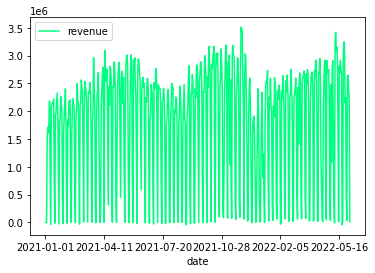

In [38]:
df1 = date_revenue.toPandas()

<AxesSubplot:xlabel='date'>

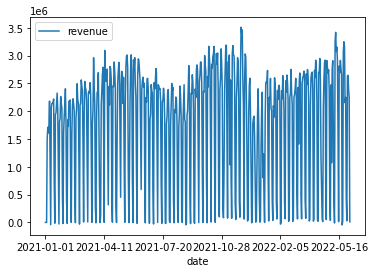

In [39]:
df1.plot(x='date', y='revenue')

### salesPB

In [ ]:
salesPB = spark.read.options(header='True', delimiter=';').csv('hdfs:///tmp/mkoroleva-309944/sales_PB.csv', inferSchema=True)

In [ ]:
cached_salesPB = salesPB.cache()

In [ ]:
cached_salesPB.printSchema()

In [ ]:
cached_sales_autodoc.unpersist()

In [ ]:
cached_salesPB.unpersist()

Saving the notebook to hdfs

In [42]:
!hdfs dfs -copyFromLocal ./ProjectBook_.ipynb /tmp/mkoroleva-309944/ProjectBook0.ipynb